# Reconstructing SIMIND Data

In [1]:
import os
from pytomography.io.SPECT import simind
from pytomography.projectors import SPECTSystemMatrix
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.transforms import GaussianFilter
from torch import poisson
import matplotlib.pyplot as plt

Set the folder location for downloaded files (you will need to modify this to be the directory where you saved the files)

In [2]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/'

## Case 1: Single Projection File

When running SIMIND simulations, it is commonly the case that organs, background, and lesions are simulated seperately and then added together in projection space after the fact. For now, lets consider the liver region, and how it would look to simulate/reconstruct a scan consisting only of a liver.

In [3]:
photopeak_path = os.path.join(path, 'multi_projections', 'liver', 'photopeak.h00')
upperscatter_path = os.path.join(path, 'multi_projections', 'liver', 'lowerscatter.h00')
lowerscatter_path = os.path.join(path, 'multi_projections', 'liver', 'upperscatter.h00')
attenuation_path = os.path.join(path, 'single_projections', 'body1.hct')

Open required metadata for reconstruction

In [4]:
object_meta, proj_meta = simind.get_metadata(photopeak_path)

Open the projection data corresponding to the photopeak:

In [5]:
photopeak = simind.get_projections(photopeak_path)

The data generated in SIMIND has units of counts per second per MBQ. A real SPECT scan has units of counts. The reason SIMIND provides these units is that
* it allows one to scale for (i) different net patient activities and (ii) different scanner acquisition times
* multiple noise realizations can be obtained. Once counts are obtained using (i) and (ii) above, the "real number" data is used as Poisson mean values, and noise realizations are generated

In [6]:
activity = 100 # MBq
projection_time = 15 #seconds, typical of Lu177 scan
photopeak = poisson(photopeak * activity * projection_time)

The projection data consists of a series of 2D images taken at different angles around the imaged object:

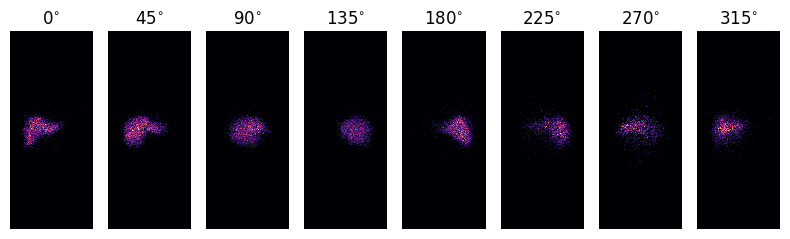

In [7]:
sample_projections = photopeak[0,::15].cpu().numpy()
sample_angles = proj_meta.angles[::15]
fig, axes = plt.subplots(1,8,figsize=(8,2.5))
for i, ax in enumerate(axes):
    ax.pcolormesh(sample_projections[i].T, cmap='magma')
    ax.set_title(f'{sample_angles[i]:.0f}'+r'$^{\circ}$')
    ax.axis('off')
fig.tight_layout()

Open the estimate for the scatter using the `get_scatter_from_TEW` method:

In [8]:
scatter = simind.get_scatter_from_TEW(
    headerfile_peak = photopeak_path,
    headerfile_lower = lowerscatter_path,
    headerfile_upper = upperscatter_path
)
scatter = poisson(scatter * activity * projection_time)

The following transform is used for attenuation correction in the system matrix. It uses a 3D attenuation map generated via SIMIND

In [9]:
attenuation_map = simind.get_attenuation_map(attenuation_path)
att_transform = SPECTAttenuationTransform(attenuation_map)

The following allows for PSF modeling in the system matrix:

In [10]:
psf_meta = simind.get_psfmeta_from_header(os.path.join(path, 'single_projections', 'body1t2ew6_tot_w2.hdr'))
psf_transform = SPECTPSFTransform(psf_meta)

Now we can build our system matrix $H$. Both the attenuation transform and PSF transform are fed to the `obj2obj_transforms` argument, with the attenuation transform coming first:

In [11]:
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta,
    n_parallel=2)

The system matrix is then used to create the reconstruction algorithm, which in this case is OSEM:

In [12]:
reconstruction_algorithm = OSEM(
    projections = photopeak,
    system_matrix = system_matrix,
    scatter = scatter)

Get the reconstructed object

In [13]:
reconstructed_object = reconstruction_algorithm(n_iters=10, n_subsets=8)

PyTomography also has functionality for Gaussian post-smoothing. In this case, we'll apply post smoothing with a 1cm FWHM.

In [14]:
post_smoothing_filter = GaussianFilter(1)
post_smoothing_filter.configure(object_meta,proj_meta)
reconstructed_object_filt = post_smoothing_filter(reconstructed_object)

Plot the reconstructed object next to the CT.
* The reconstructed object has units of counts, and would need to be adjusted by a proportionality factor if one wants to obtain units of MBq

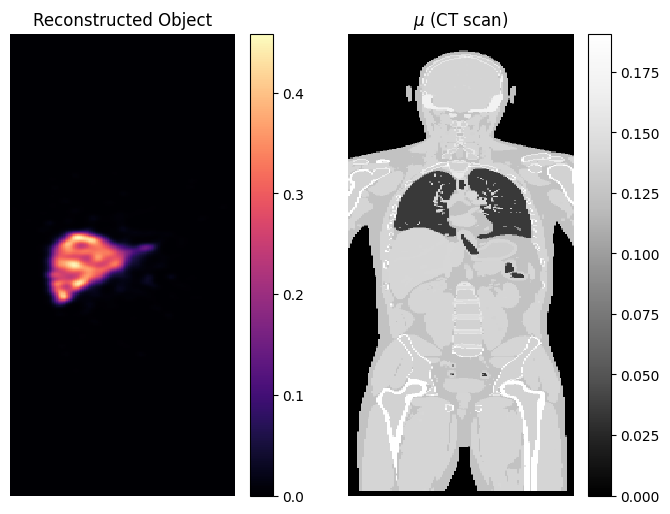

In [15]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(reconstructed_object_filt[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(attenuation_map.cpu()[0][:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()

## Case 2: Multiple Regions

When running simulations with SIMIND, it is standard to run different regions of the body seperately and then combine them together in projection space after the fact. This enables one to create arbtrary organ activities using the same set of simulated data. A few noteworthy things

* SIMIND projection data is typically given in units of CPS/MBq where CPS=counts/second. Real life SPECT data consists of units of counts. In order to simulate a realistic scenario, therefore, we need to multiply the projections by some value in MBq, and some value in seconds. The value in MBq corresponds to the total activity of the organ/region you've simulated. The value in seconds corresponds to the total projection time.

We'll start by opening up SIMIND projections corresponding to 8 distinct regions of the body, each with activities representative of a true clinical case

In [16]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]

Open the projection/scatter data

In [17]:
object_meta, proj_meta = simind.get_metadata(headerfiles[0]) #assumes the same for all
photopeak = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)

Note that our `weights` were in units of MBq, so our projection data currently has units of counts/second.

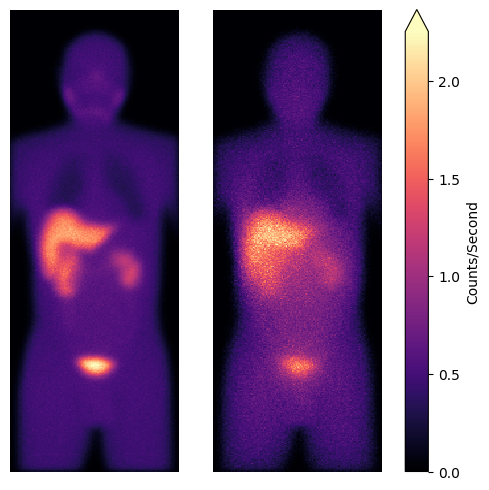

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
im = plt.pcolormesh(photopeak[0,0].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='magma')
plt.axis('off')
fig.colorbar(im, ax=ax, location='right', label='Counts/Second', extend='max')

Now we need to decide how long the scan was taken for. We'll assume each projection was taken for 15 seconds

In [19]:
dT = 15 #s
photopeak *= dT
scatter *= dT

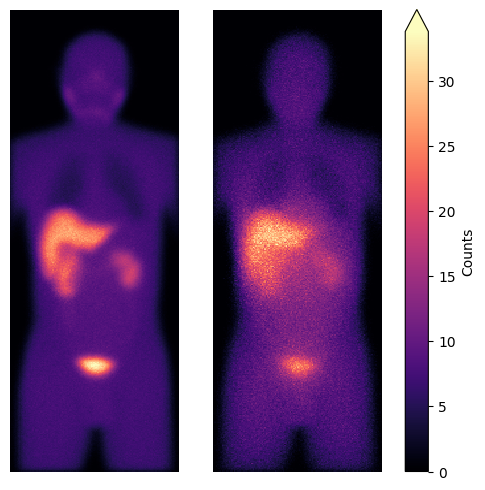

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
im = plt.pcolormesh(photopeak[0,0].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='magma')
plt.axis('off')
fig.colorbar(im, ax=ax, location='right', label='Counts', extend='max')

In realtity, SPECT projection data is noisy. Provided enough events are ran during the SIMIND simulation, the SIMIND data is essentially noise-free. We need to add Poisson noise if we are to simulate a realistic clinical imaging scenario

In [21]:
photopeak_poisson = poisson(photopeak)
scatter_poisson = poisson(scatter)

Now can look at our realistic noisy data:

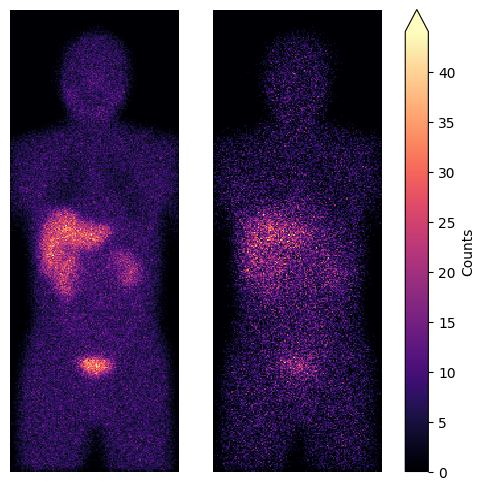

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
im = plt.pcolormesh(photopeak_poisson[0,0].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(scatter_poisson[0,0].cpu().T, cmap='magma')
plt.axis('off')
fig.colorbar(im, ax=ax, location='right', label='Counts', extend='max')

Now the projection and scatter data is representative of a realistic clinical scenario. Now we reconstruct as we did earlier.

In [23]:
attenuation_map = simind.get_attenuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta)
reconstruction_algorithm = OSEM(
    projections = photopeak_poisson,
    system_matrix = system_matrix,
    scatter = scatter_poisson)

Now we reconstruct:

In [24]:
reconstructed_object = reconstruction_algorithm(n_iters=10, n_subsets=8)

Lets see the reconstructed object

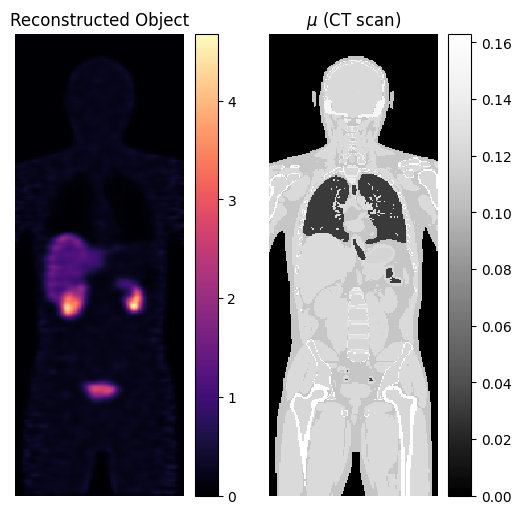

In [25]:
plt.subplots(1,2,figsize=(6,6))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(attenuation_map.cpu()[0][:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()